<a href="https://colab.research.google.com/github/mthsansu/MLNLP/blob/main/Code/Baseline_qui_fonctionne.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1><center><strong><font color="chillipepper">Parlementarian Sentiment Analysis: Sequence Classification</font></strong></center></h1>
<h3><center><font color="green"><strong>Baseline Model</strong></font></center></h3>

<center>
April 2022, Houri & Sansu
</center>

## <font color="chillipepper">Modules and packages</font>

In [23]:
!pip install datasets

In [24]:
import torch
import numpy as np
import datasets
from datasets import load_dataset
from tqdm import tqdm
import nltk
from nltk.tokenize import TreebankWordTokenizer, TweetTokenizer
import pandas as pd
from collections import Counter
import torchtext
from sklearn.model_selection import train_test_split
from termcolor import colored
import torch
import torch.nn as nn
import torch.nn.functional as F

## <font color="chillipepper">Data</font>

**Import the annotated data**

In [25]:
# Import data
git_url = "https://raw.githubusercontent.com/mthsansu/MLNLP/main/Data/"
df = pd.read_csv(git_url + 'df_baseline.csv')

In [26]:
df = df.drop(columns=['Unnamed: 0'])
df = df.rename(columns={'Label': 'label'})

**Prepare the data for machine learning tasks**

In [27]:
train, validate, test = \
              np.split(df.sample(frac=1, random_state=42), 
                       [int(.6*len(df)), int(.8*len(df))])

In [28]:
import pyarrow as pa
import pyarrow.dataset as ds
from datasets import Dataset

# dataset = ds.dataset(pa.Table.from_pandas(df).to_batches())
# dataset = ds.dataset(pa.Table.from_pandas(train).to_batches())

### convert to Huggingface dataset
train_dataset = Dataset(pa.Table.from_pandas(train))

## <font color="chillipepper">Pre-trained Embeddings</font>

**First NLP tasks**

In [29]:
# Run only once: several min long
# fasttext vectors can be imported through torch text (it will download it only once)
from torchtext.vocab import GloVe, vocab, FastText

# pretrained_vectors = GloVe(name="6B", dim='50')
pretrained_vectors = FastText(language='fr')

In [30]:
from torchtext.vocab import GloVe, FastText, vocab

pretrained_vocab = vocab(pretrained_vectors.stoi)
unk_token = "<unk>"
unk_index = 0
pad_token = '<pad>'
pad_index = 1
pretrained_vocab.insert_token("<unk>",unk_index)
pretrained_vocab.insert_token("<pad>", pad_index)
#this is necessary otherwise it will throw runtime error if OOV token is queried 
pretrained_vocab.set_default_index(unk_index)
pretrained_embeddings = pretrained_vectors.vectors
pretrained_embeddings = torch.cat((torch.zeros(1,pretrained_embeddings.shape[1]),pretrained_embeddings))
pretrained_embeddings.size()

torch.Size([1152450, 300])

## <font color="chillipepper">Tokenization</font>

In [31]:
from nltk.tokenize import TweetTokenizer
from tqdm.notebook import tqdm

tok = TweetTokenizer()

In [32]:
def tokenize_pad_numericalize(entry, vocab_stoi, max_length=20):
  text = [ vocab_stoi[token] if token in vocab_stoi else vocab_stoi['<unk>'] for token in tok.tokenize(entry.lower())]
  padded_text = None
  if len(text) < max_length:   padded_text = text + [ vocab_stoi['<pad>'] for i in range(len(text), max_length) ] 
  elif len(text) > max_length: padded_text = text[:max_length]
  else:                        padded_text = text
  return padded_text

def tokenize_all(entries, vocab_stoi):
  res = {}
  res['text'] = [tokenize_pad_numericalize(entry, vocab_stoi, max_length=200) for entry in entries['text']]
  res['label'] = entries['label']
  return res

train_dataset = train_dataset.map(lambda e: tokenize_all(e, pretrained_vocab.get_stoi()), batched=True)

  0%|          | 0/1 [00:00<?, ?ba/s]

In [33]:
print(train_dataset['label'])

[1, 0, 1, 0, 1, 1, 2, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 2, 0, 1, 0, 2, 1, 2, 1, 0, 0, 0, 1, 0, 1, 2, 1, 0, 1, 0, 0, 0, 1, 2, 1, 0, 0, 1, 0, 2, 2, 2, 2, 2, 2, 1, 2, 0, 2, 0, 0, 0, 2, 2, 0, 1, 1, 0, 2, 2, 0, 1, 2, 0, 1, 1, 1, 2, 0, 1, 0, 0, 2, 1, 1, 1, 2, 0, 2, 2, 0, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 0, 2, 1, 1, 2, 0, 1, 2, 0, 2, 2, 0, 1, 1, 0, 0, 0, 1, 1, 1, 2, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 2, 0, 0, 0, 0, 1, 2, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 2, 1, 2, 1, 0, 1, 2, 1, 2, 0, 0, 1, 0, 1, 1, 0, 1, 2, 2, 0, 0, 0, 1, 0, 0, 0, 1, 2, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 2, 1, 2, 1, 0, 2, 1, 1, 2, 2, 0, 2, 2, 1, 0, 0, 0, 0, 1, 1, 2, 2, 0, 1, 2, 0, 0, 0, 1, 1, 2, 1, 2, 1, 2, 2, 0, 1, 0, 2, 1, 2, 1, 2, 0, 1, 0, 2, 0, 1, 1, 0, 1, 2, 1, 2, 1, 2, 1, 1, 1, 0, 2, 2, 1, 1, 1, 0, 1, 2, 2, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 2, 1, 0, 0, 1, 0, 1, 2, 2, 0, 1, 1, 2, 2, 1, 2, 1, 0, 1, 0, 0, 2, 0, 1, 1, 0, 0, 0, 2, 1, 0, 2, 0, 0, 1, 0, 1, 1, 2, 0, 1, 1, 0, 2, 2, 1, 0, 1, 1, 2, 0, 1, 0, 2, 1, 

In [34]:
# dataset = ds.dataset(pa.Table.from_pandas(test).to_batches())

### convert to Huggingface dataset
test_dataset = Dataset(pa.Table.from_pandas(test))

# tokenize
test_dataset = test_dataset.map(lambda e: tokenize_all(e, pretrained_vocab.get_stoi()), batched=True)

  0%|          | 0/1 [00:00<?, ?ba/s]

In [35]:
print(test_dataset['label'])

[2, 1, 2, 0, 1, 2, 0, 0, 1, 1, 0, 2, 1, 0, 0, 0, 2, 1, 0, 1, 1, 2, 0, 0, 0, 2, 2, 0, 2, 1, 1, 2, 0, 0, 0, 2, 0, 2, 2, 0, 0, 1, 1, 0, 0, 1, 0, 2, 1, 2, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 2, 2, 0, 0, 2, 0, 0, 0, 1, 0, 1, 2, 0, 0, 0, 2, 2, 1, 0, 2, 1, 0, 1, 1, 2, 2, 1, 0, 0, 0, 0, 1, 2, 1, 1, 1, 1, 1, 2, 0, 0, 2, 1, 1, 2, 1, 0, 1, 1, 0, 0, 1, 2, 2, 1, 1, 0, 1, 2, 2, 2, 2, 1, 1, 0, 0, 0, 0, 2, 2, 1, 2, 0, 2, 0, 0, 0, 2, 2, 2, 1, 1, 2, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 2, 0, 0, 0, 1, 1, 0, 2, 2, 1, 0, 0, 1, 1, 2, 1, 1, 2, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1]


In [36]:
# dataset = ds.dataset(pa.Table.from_pandas(test).to_batches())

### convert to Huggingface dataset
val_dataset = Dataset(pa.Table.from_pandas(validate))

# tokenize
val_dataset = val_dataset.map(lambda e: tokenize_all(e, pretrained_vocab.get_stoi()), batched=True)

  0%|          | 0/1 [00:00<?, ?ba/s]

In [37]:
print(val_dataset['label'])

[2, 1, 2, 0, 1, 0, 2, 0, 1, 2, 1, 2, 0, 0, 0, 2, 1, 1, 0, 2, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 2, 2, 0, 0, 0, 1, 1, 2, 1, 0, 0, 2, 0, 0, 1, 2, 0, 1, 1, 2, 1, 1, 2, 1, 1, 0, 0, 0, 2, 0, 1, 0, 0, 0, 1, 0, 0, 2, 1, 0, 1, 0, 1, 0, 1, 1, 2, 2, 0, 0, 0, 0, 1, 1, 0, 2, 0, 0, 2, 1, 2, 0, 0, 2, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 2, 2, 0, 2, 0, 2, 1, 0, 0, 1, 1, 1, 1, 0, 1, 2, 0, 0, 0, 1, 1, 1, 0, 2, 2, 2, 2, 1, 2, 2, 0, 1, 1, 0, 1, 1, 0, 1, 0, 2, 0, 0, 0, 0, 0, 1, 0, 0, 2, 0, 0, 0, 1, 1, 1, 0, 0, 2, 1, 0, 2, 0, 1, 2, 2, 2, 0, 0, 1, 0, 0, 2, 0, 1, 1, 0, 2, 0, 2, 1, 2, 0, 0, 1, 1, 2, 2, 0, 0, 0, 0, 0, 1, 0, 2, 0]


## <font color="chillipepper">Building of the model</font>

In [38]:
# Create the Dataset class

from torch.utils.data import Dataset
import numpy as np

class TweetDataset(Dataset):
    def __init__(self, data, args):
      # args is a dict, a nice way to share the global arguments (even accross multiple files)
      self.args = args
      self.data = data

    def __len__(self):
      return len(self.data)
    
    def __getitem__(self, idx):
      item = {
          "text": np.array(self.data[idx]['text']),
          "label": np.array(self.data[idx]['label'])
      }
      # warning: if you put   self.data['text'][idx]    it will take A LOT of time...
      ## The following code would take forever just to print next(iter(train_loader))['text'].shape
      # item = {
      #     "text": np.array(self.data['text'][idx]),
      #     "label": np.array(self.data['label'][idx])
      # }
      return item

In [39]:
# Create the data loader

# Create DataLoader
from torch.utils.data import DataLoader
args = {'bsize': 64}
train_loader = DataLoader(TweetDataset(train_dataset, args), batch_size=args['bsize'], num_workers=2, shuffle=True, drop_last=True)
test_loader  = DataLoader(TweetDataset(test_dataset, args), batch_size=args['bsize'], num_workers=2, shuffle=True, drop_last=True)
val_loader  = DataLoader(TweetDataset(val_dataset, args), batch_size=args['bsize'], num_workers=2, shuffle=True, drop_last=True)

In [40]:
# Define the model to classify tweets

class TweetModel(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, pretrained_vectors=None):
        """
        In the constructor we instantiate two nn.Linear modules and assign them as
        member variables.
        """
        super(TweetModel, self).__init__()
        # apply the pretrained embeddings to transform our token indices, into vectors
        self.ebd = torch.nn.Embedding.from_pretrained(pretrained_vectors, freeze=True)
        self.hidden_linear_layer = torch.nn.Linear(hidden_dim, hidden_dim, bias=True)
        self.classification_layer = torch.nn.Linear(hidden_dim, output_dim, bias=True)
        # softmax layer to compute class probabilities
        # https://pytorch.org/docs/stable/generated/torch.nn.Softmax.html?highlight=softmax#torch.nn.Softmax
        self.softmax = nn.Softmax(dim=1)

        # define the dropout strategy (here, 20% (0.2) of the vector is ignored to prevent overfitting)
        # we don't use it here but it's a good thing to keep in mind
        # self.dropout = nn.Dropout(p=0.2)

    def forward(self, x):
        """
        In the forward function we accept a Tensor of input data and we must return
        a Tensor of output data. We can use Modules defined in the constructor as
        well as arbitrary operators on Tensors.
        """
        # apply the pretrained embeddings
        x  = self.ebd(x)
        x  = x.mean(1)
        h  = torch.relu(self.hidden_linear_layer( x ))
        # h  = self.dropout(h)
        h  = self.classification_layer(h)
        logits = self.softmax(h)
        return logits

In [41]:
sizes = next(iter(train_loader))['text'].size()
batchsize = sizes[0]
inputdim  = sizes[1]
print(batchsize, inputdim)

64 200


In [42]:
hiddendim = 300 # dimension of the pretrained vector
outputdim = 3 # because there is 3 classes, i.e. 3 labels
# we instanciate the model
tweet_model = TweetModel(inputdim, hiddendim, outputdim, pretrained_vectors=pretrained_vectors.vectors)

In [43]:
# we can look at the model 
tweet_model

TweetModel(
  (ebd): Embedding(1152449, 300)
  (hidden_linear_layer): Linear(in_features=300, out_features=300, bias=True)
  (classification_layer): Linear(in_features=300, out_features=3, bias=True)
  (softmax): Softmax(dim=1)
)

**We'll need a GPU**

In [44]:
if torch.cuda.is_available():
  device = 'cuda'
  print('DEVICE = ', colored(torch.cuda.get_device_name(0), "green" ) )
else:
  device = 'cpu'
  print('DEVICE = ', colored('CPU', "blue"))
tweet_model.to(device)

DEVICE =  CPU


TweetModel(
  (ebd): Embedding(1152449, 300)
  (hidden_linear_layer): Linear(in_features=300, out_features=300, bias=True)
  (classification_layer): Linear(in_features=300, out_features=3, bias=True)
  (softmax): Softmax(dim=1)
)

**Train the model**

In [45]:
# Training loop

def train(model, optimizer, ep, args):
  # set the model into a training mode : the model's weights and parameters WILL BE updated!
  model.train()
  # initialize empty lists for losses and accuracies
  loss_it, acc_it = list(), list()

  # start the loop over all the training batches. This means one full epoch.
  for it, batch in tqdm(enumerate(train_loader), desc="Epoch %s:" % (ep), total=train_loader.__len__()):
    
    batch = {'text': batch['text'].to(device), 'label': batch['label'].to(device)}

    # put parameters of the model and the optimizer to zero before doing another iteration. this prevents the gradient accumulation through batches
    optimizer.zero_grad()

    # apply the model on the batch
    logits = model(batch['text'])

    # # # to deal with unbalanced data in the batch, we calculate the weights according to their inverse frequency
    b_counter = Counter(batch['label'].detach().cpu().tolist())
    b_weights = torch.tensor( [ sum(batch['label'].detach().cpu().tolist()) / b_counter[label] if b_counter[label] > 0 else 0 for label in list(range(args['num_class'])) ] )
    b_weights = b_weights.to(device)

    # we choose the CrossEntropyLoss, suitable for multiclass classification
    # https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html#torch.nn.CrossEntropyLoss
    loss_function = nn.CrossEntropyLoss(weight=b_weights)
    # loss_function = nn.CrossEntropyLoss()
    loss = loss_function(logits, batch['label'])

    # compute backpropagation
    loss.backward()

    # indicate to the optimizer we've done a step
    optimizer.step()

    # append the value of the loss for the current iteration (it). .item() retrieve the nuclear value as a int/long
    loss_it.append(loss.item())

    # get the predicted tags using the maximum probability from the softmax
    _, tag_seq  = torch.max(logits, 1)
    
    # Those 3 lines compute the accuracy and then append it the same way as the loss above
    correct = (tag_seq.flatten() == batch['label'].flatten()).float().sum()
    acc = correct / batch['label'].flatten().size(0)
    acc_it.append(acc.item())

  # simple averages of losses and accuracies for this epoch
  loss_it_avg = sum(loss_it)/len(loss_it)
  acc_it_avg = sum(acc_it)/len(acc_it)
  
  # print useful information about the training progress and scores on this training set's full pass (i.e. 1 epoch)
  print("Epoch %s/%s : %s : (%s %s) (%s %s)" % (colored(str(ep), 'blue'),args['max_eps'] , colored('Training', 'blue'), colored('loss', 'cyan'), sum(loss_it)/len(loss_it), colored('acc', 'cyan'), sum(acc_it) / len(acc_it)))


In [46]:
def inference(target, loader, model):
  """
    Args:
      target (str): modify the display, usually either 'validation' or 'test'
  """

  # set the model into a evaluation mode : the model's weights and parameters will NOT be updated!
  model.eval()

  # intialize empty list to populate later on
  loss_it, acc_it, f1_it = list(), list(), list()
  # preds = predicted values ; trues = true values .... obviously~
  preds, trues = list(), list()

  # loop over the loader batches
  for it, batch in tqdm(enumerate(loader), desc="%s:" % (target), total=loader.__len__()):
    # set an environnement without any gradient. So the tensor gradients are not considered 
    # (saves a lot of computation and memory, this is one of the many things that makes predicting far less costly than training)
    with torch.no_grad():

      # put the batch to the correct device
      batch = {'text': batch['text'].to(device), 'label': batch['label'].to(device)}

      # apply the model
      logits = model(batch['text'])

      # # to deal with unbalanced data in the batch, we calculate the weights according to their inverse frequency
      # b_counter = Counter(batch['label'].detach().cpu().tolist())
      # b_weights = torch.tensor( [ sum(batch['label'].detach().cpu().tolist()) / b_counter[label] if b_counter[label] > 0 else 0 for label in list(range(20)) ] )
      # b_weights = b_weights.to(device)

      # loss_function = nn.CrossEntropyLoss(weight=b_weights)
      loss_function = nn.CrossEntropyLoss()
      loss = loss_function(logits, batch['label'])

      # no need to backward() and other training stuff. Directly store the loss in the list
      loss_it.append(loss.item())

      # get the predicted tags using the maximum probability from the softmax
      _, tag_seq  = torch.max(logits, 1)
      
      # compute the accuracy and store it
      correct = (tag_seq.flatten() == batch['label'].flatten()).float().sum()
      acc = correct / batch['label'].flatten().size(0)
      acc_it.append(acc.item())
      
      # extend the predictions and true labels lists so we can compare them later on
      # note how we first ensure the tensor are on cpu (.cpu()), then we detach() the gradient from the tensor, before transforming it to a simple python list (.tolist())
      preds.extend(tag_seq.cpu().detach().tolist())
      trues.extend(batch['label'].cpu().detach().tolist())

  # compute the average loss and accuracy accross the iterations (batches)
  loss_it_avg = sum(loss_it)/len(loss_it)
  acc_it_avg = sum(acc_it)/len(acc_it)
  
  # print useful information. Important during training as we want to know the performance over the validation set after each epoch
  print("%s : (%s %s) (%s %s)" % ( colored(target, 'blue'), colored('loss', 'cyan'), sum(loss_it)/len(loss_it), colored('acc', 'cyan'), sum(acc_it) / len(acc_it)))

  # return the true and predicted values with the losses and accuracies
  return trues, preds, loss_it_avg, acc_it_avg, loss_it, acc_it

In [47]:
# Start training

import torch.optim as optim

def run_epochs(model, args):

  args['device'] =device
  # if args['cuda'] != -1:
  #     model.cuda(args['cuda'])
  #     device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  #     args['device'] = device
  #     print("device set to %s" % (device) )

  # we set the optimizer as Adam with the learning rate (lr) set in the arguments
  # you can look at the different optimizer available here: https://pytorch.org/docs/stable/optim.html
  optimizer = optim.Adam(model.parameters(), lr = args['lr'])

  # define an empty list to store validation losses for each epoch
  val_ep_losses = list()
  # iterate over the number of max epochs set in the arguments
  for ep in range(args['max_eps']):
    # train the model using our defined function
    train(model, optimizer, ep, args)
    # apply the model for inference using our defined function
    trues, preds, val_loss_it_avg, val_acc_it_avg, val_loss_it, val_acc_it = inference("validation", val_loader, model)
    # append the validation losses (good losses should normally go down)
    val_ep_losses.append(val_loss_it_avg)

  # return the list of epoch validation losses in order to use it later to create a plot
  return val_ep_losses
    

In [48]:
# here you can specify if you want a GPU or a CPU by setting the cuda argument as -1 for CPU and another index for GPU. If you only have one GPU, put 0.
args.update({'max_eps': 80, 'lr': 0.001, 'device': 'cpu', 'cuda': 0, 'num_class': 3})
# 1e-05
print('device', device)
# Instantiate model with pre-trained glove vectors
# model = TweetModel(pretrained_embeddings, args['num_class'], args, dimension=50, freeze_embeddings = True )
tweet_model = TweetModel(inputdim, hiddendim, outputdim, pretrained_vectors=pretrained_vectors.vectors)
loss_list_val = run_epochs(tweet_model, args)

device cpu


Epoch 0::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 0/80 : Training : (loss 1.0978279113769531) (acc 0.3871527777777778)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.09624183177948) (acc 0.4427083333333333)


Epoch 1::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 1/80 : Training : (loss 1.0955284701453314) (acc 0.3958333333333333)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0933825174967449) (acc 0.421875)


Epoch 2::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 2/80 : Training : (loss 1.0917793247434828) (acc 0.3993055555555556)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0879813432693481) (acc 0.4270833333333333)


Epoch 3::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 3/80 : Training : (loss 1.0867509444554646) (acc 0.3975694444444444)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0870095094045003) (acc 0.4166666666666667)


Epoch 4::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 4/80 : Training : (loss 1.0807226763831244) (acc 0.4131944444444444)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0781800349553425) (acc 0.421875)


Epoch 5::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 5/80 : Training : (loss 1.0737063354916043) (acc 0.3993055555555556)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0749648412068684) (acc 0.4166666666666667)


Epoch 6::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 6/80 : Training : (loss 1.0686454508039687) (acc 0.4305555555555556)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0696053107579548) (acc 0.40625)


Epoch 7::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 7/80 : Training : (loss 1.0644710726208158) (acc 0.4236111111111111)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0647652546564739) (acc 0.3958333333333333)


Epoch 8::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 8/80 : Training : (loss 1.0616423156526353) (acc 0.4253472222222222)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0596834421157837) (acc 0.421875)


Epoch 9::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 9/80 : Training : (loss 1.056332853105333) (acc 0.421875)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0801531473795574) (acc 0.3958333333333333)


Epoch 10::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 10/80 : Training : (loss 1.0542024506462946) (acc 0.4305555555555556)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0904592672983806) (acc 0.3802083333333333)


Epoch 11::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 11/80 : Training : (loss 1.0526729557249281) (acc 0.4166666666666667)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.074957052866618) (acc 0.4166666666666667)


Epoch 12::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 12/80 : Training : (loss 1.0468961927625868) (acc 0.4184027777777778)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0587078332901) (acc 0.4166666666666667)


Epoch 13::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 13/80 : Training : (loss 1.0502073102527194) (acc 0.4131944444444444)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0676545699437459) (acc 0.4166666666666667)


Epoch 14::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 14/80 : Training : (loss 1.0480096737543743) (acc 0.4253472222222222)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0837238629659016) (acc 0.4166666666666667)


Epoch 15::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 15/80 : Training : (loss 1.0460809469223022) (acc 0.4444444444444444)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0594015916188557) (acc 0.40625)


Epoch 16::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 16/80 : Training : (loss 1.0438854694366455) (acc 0.4357638888888889)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0604947010676067) (acc 0.4166666666666667)


Epoch 17::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 17/80 : Training : (loss 1.0366540087593927) (acc 0.4548611111111111)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0712135235468547) (acc 0.4114583333333333)


Epoch 18::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 18/80 : Training : (loss 1.0427917904324002) (acc 0.4409722222222222)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0880704720815022) (acc 0.3958333333333333)


Epoch 19::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 19/80 : Training : (loss 1.0313637124167547) (acc 0.4444444444444444)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0760351816813152) (acc 0.40625)


Epoch 20::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 20/80 : Training : (loss 1.0359498858451843) (acc 0.4513888888888889)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0719918807347615) (acc 0.4166666666666667)


Epoch 21::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 21/80 : Training : (loss 1.036586629019843) (acc 0.4583333333333333)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0775587558746338) (acc 0.4166666666666667)


Epoch 22::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 22/80 : Training : (loss 1.0313623083962336) (acc 0.4739583333333333)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0788689057032268) (acc 0.3958333333333333)


Epoch 23::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 23/80 : Training : (loss 1.032872584131029) (acc 0.4652777777777778)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.062013864517212) (acc 0.3958333333333333)


Epoch 24::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 24/80 : Training : (loss 1.031904763645596) (acc 0.4722222222222222)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.065521478652954) (acc 0.4010416666666667)


Epoch 25::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 25/80 : Training : (loss 1.032642536693149) (acc 0.4756944444444444)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.087633768717448) (acc 0.390625)


Epoch 26::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 26/80 : Training : (loss 1.0320032835006714) (acc 0.4774305555555556)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0766286849975586) (acc 0.40625)


Epoch 27::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 27/80 : Training : (loss 1.027723299132453) (acc 0.4722222222222222)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.073007623354594) (acc 0.3854166666666667)


Epoch 28::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 28/80 : Training : (loss 1.0248730646239386) (acc 0.5086805555555556)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0785479148228962) (acc 0.4166666666666667)


Epoch 29::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 29/80 : Training : (loss 1.0245446628994412) (acc 0.4930555555555556)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0724833011627197) (acc 0.390625)


Epoch 30::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 30/80 : Training : (loss 1.0271320740381877) (acc 0.4791666666666667)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0874896049499512) (acc 0.3854166666666667)


Epoch 31::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 31/80 : Training : (loss 1.032144460413191) (acc 0.5069444444444444)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0983316500981648) (acc 0.3802083333333333)


Epoch 32::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 32/80 : Training : (loss 1.0258956087960138) (acc 0.4947916666666667)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0611896912256877) (acc 0.4270833333333333)


Epoch 33::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 33/80 : Training : (loss 1.0264003740416632) (acc 0.4965277777777778)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0854121843973796) (acc 0.3802083333333333)


Epoch 34::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 34/80 : Training : (loss 1.0203191041946411) (acc 0.5399305555555556)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0869555870691936) (acc 0.3802083333333333)


Epoch 35::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 35/80 : Training : (loss 1.0197228060828314) (acc 0.5086805555555556)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0680349270502727) (acc 0.3854166666666667)


Epoch 36::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 36/80 : Training : (loss 1.017357607682546) (acc 0.5086805555555556)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0648312171300252) (acc 0.4010416666666667)


Epoch 37::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 37/80 : Training : (loss 1.0181839134958055) (acc 0.5381944444444444)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0962820053100586) (acc 0.359375)


Epoch 38::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 38/80 : Training : (loss 1.0123704142040677) (acc 0.53125)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.060512860616048) (acc 0.4322916666666667)


Epoch 39::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 39/80 : Training : (loss 1.0172934134801228) (acc 0.4861111111111111)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0869431893030803) (acc 0.3854166666666667)


Epoch 40::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 40/80 : Training : (loss 1.0107683539390564) (acc 0.546875)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0691624482472737) (acc 0.4166666666666667)


Epoch 41::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 41/80 : Training : (loss 1.0102845231691997) (acc 0.5138888888888888)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0755680402119954) (acc 0.4166666666666667)


Epoch 42::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 42/80 : Training : (loss 1.0164099865489535) (acc 0.5711805555555556)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0722586711247761) (acc 0.3802083333333333)


Epoch 43::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 43/80 : Training : (loss 1.0165519648128085) (acc 0.4826388888888889)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0800800323486328) (acc 0.4166666666666667)


Epoch 44::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 44/80 : Training : (loss 1.0074422359466553) (acc 0.515625)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0684033632278442) (acc 0.4010416666666667)


Epoch 45::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 45/80 : Training : (loss 1.0089300804668002) (acc 0.5607638888888888)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0822049379348755) (acc 0.3802083333333333)


Epoch 46::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 46/80 : Training : (loss 1.0071951217121549) (acc 0.5694444444444444)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.063886046409607) (acc 0.390625)


Epoch 47::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 47/80 : Training : (loss 0.998598489496443) (acc 0.5555555555555556)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.079380472501119) (acc 0.3854166666666667)


Epoch 48::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 48/80 : Training : (loss 1.0044310887654622) (acc 0.5295138888888888)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0662466684977214) (acc 0.3854166666666667)


Epoch 49::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 49/80 : Training : (loss 0.994613250096639) (acc 0.5815972222222222)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0842893520991008) (acc 0.3854166666666667)


Epoch 50::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 50/80 : Training : (loss 1.000932342476315) (acc 0.5763888888888888)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.079063614209493) (acc 0.390625)


Epoch 51::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 51/80 : Training : (loss 0.9912729859352112) (acc 0.578125)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0574910243352253) (acc 0.421875)


Epoch 52::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 52/80 : Training : (loss 0.994418289926317) (acc 0.5659722222222222)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.1001014709472656) (acc 0.390625)


Epoch 53::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 53/80 : Training : (loss 1.0011846092012193) (acc 0.578125)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.074371616045634) (acc 0.3802083333333333)


Epoch 54::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 54/80 : Training : (loss 0.9936302502950033) (acc 0.5659722222222222)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0830626487731934) (acc 0.40625)


Epoch 55::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 55/80 : Training : (loss 0.9953502085473802) (acc 0.5659722222222222)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0740324258804321) (acc 0.4322916666666667)


Epoch 56::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 56/80 : Training : (loss 0.9862351218859354) (acc 0.5555555555555556)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.061533252398173) (acc 0.4427083333333333)


Epoch 57::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 57/80 : Training : (loss 0.9947121408250597) (acc 0.5503472222222222)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0799118280410767) (acc 0.421875)


Epoch 58::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 58/80 : Training : (loss 0.9855478737089369) (acc 0.5868055555555556)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.069787581761678) (acc 0.421875)


Epoch 59::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 59/80 : Training : (loss 0.9887148936589559) (acc 0.5659722222222222)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0758566856384277) (acc 0.3958333333333333)


Epoch 60::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 60/80 : Training : (loss 0.9884580969810486) (acc 0.5572916666666666)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0952674547831218) (acc 0.375)


Epoch 61::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 61/80 : Training : (loss 0.978767090373569) (acc 0.5815972222222222)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0715425411860149) (acc 0.3802083333333333)


Epoch 62::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 62/80 : Training : (loss 0.9802888300683763) (acc 0.5815972222222222)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0900012254714966) (acc 0.3541666666666667)


Epoch 63::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 63/80 : Training : (loss 0.9820524785253737) (acc 0.5989583333333334)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0770869652430217) (acc 0.390625)


Epoch 64::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 64/80 : Training : (loss 0.9789649711714851) (acc 0.5746527777777778)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0751666227976482) (acc 0.4114583333333333)


Epoch 65::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 65/80 : Training : (loss 0.9808448023266263) (acc 0.5833333333333334)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.065411369005839) (acc 0.4427083333333333)


Epoch 66::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 66/80 : Training : (loss 0.975424587726593) (acc 0.5833333333333334)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0639739036560059) (acc 0.421875)


Epoch 67::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 67/80 : Training : (loss 0.976595401763916) (acc 0.5989583333333334)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0840415954589844) (acc 0.40625)


Epoch 68::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 68/80 : Training : (loss 0.9774746894836426) (acc 0.5902777777777778)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.063808759053548) (acc 0.4427083333333333)


Epoch 69::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 69/80 : Training : (loss 0.97205032242669) (acc 0.5729166666666666)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0917086203893025) (acc 0.390625)


Epoch 70::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 70/80 : Training : (loss 0.9728567534022861) (acc 0.5850694444444444)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0671360492706299) (acc 0.3958333333333333)


Epoch 71::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 71/80 : Training : (loss 0.9729655782381693) (acc 0.6006944444444444)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0819360415140789) (acc 0.4166666666666667)


Epoch 72::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 72/80 : Training : (loss 0.9709703988499112) (acc 0.6197916666666666)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0650514761606853) (acc 0.3958333333333333)


Epoch 73::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 73/80 : Training : (loss 0.9662093122800192) (acc 0.625)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.075872818628947) (acc 0.4166666666666667)


Epoch 74::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 74/80 : Training : (loss 0.9627186589770846) (acc 0.6128472222222222)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0759608348210652) (acc 0.4010416666666667)


Epoch 75::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 75/80 : Training : (loss 0.9701187279489305) (acc 0.5954861111111112)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0695624748865764) (acc 0.453125)


Epoch 76::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 76/80 : Training : (loss 0.9591034717029996) (acc 0.5954861111111112)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0677212079366047) (acc 0.4375)


Epoch 77::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 77/80 : Training : (loss 0.9659125142627292) (acc 0.578125)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0748046239217122) (acc 0.453125)


Epoch 78::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 78/80 : Training : (loss 0.967924541897244) (acc 0.578125)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0729612906773884) (acc 0.453125)


Epoch 79::   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 79/80 : Training : (loss 0.9628405703438653) (acc 0.6024305555555556)


validation::   0%|          | 0/3 [00:00<?, ?it/s]

validation : (loss 1.0756443738937378) (acc 0.4270833333333333)


**Evaluate the model**

In [53]:
# let's use our model for inference on the test set. We can short it by naming it "test our model"
# we set the target as "test" to print the correct info, and use the test loader
trues, preds, loss_it_avg, acc_it_avg, loss_it, acc_it = inference("test", test_loader, tweet_model)

test::   0%|          | 0/3 [00:00<?, ?it/s]

test : (loss 1.0013014872868855) (acc 0.5572916666666666)


In [54]:
set(preds)

{0, 1, 2}

In [55]:
names = [0,1,2]

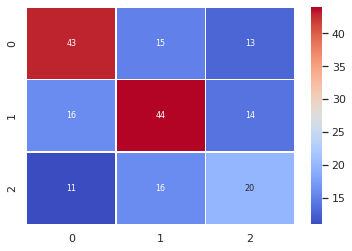

In [56]:
# Confusion matrix

from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, plot_roc_curve
import matplotlib.pyplot as plt
import seaborn as sn

cm = confusion_matrix(np.array(trues).flatten(), np.array(preds).flatten())
df_cm = pd.DataFrame(cm, index=names, columns=names)
# config plot sizes
sn.set(font_scale=1)
sn.heatmap(df_cm, annot=True, annot_kws={"size": 8}, cmap='coolwarm', linewidth=0.5, fmt="")
plt.show()